In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('ggplot')
plt.rcParams['figure.figsize'] = (11, 6)
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('DATA/RSCCASN.csv', parse_dates=True, index_col='DATE')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [5]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01'],
              dtype='datetime64[ns]', name='DATE', length=334, freq=None)

In [6]:
df.columns = ['Sales']

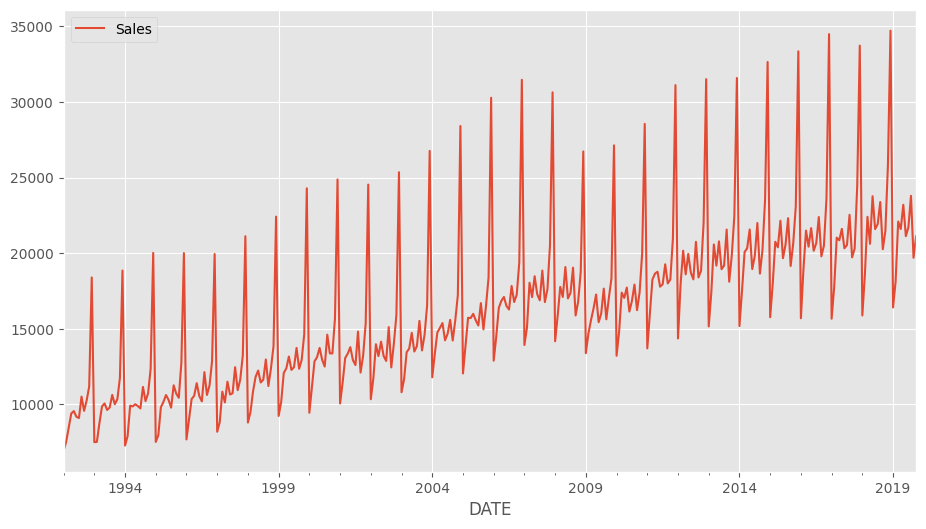

In [8]:
df.plot();

In [9]:
len(df)

334

In [11]:
test_size =  18

In [12]:
test_ind = len(df) - test_size

In [13]:
train = df.iloc[:test_ind]

In [14]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
1992-06-01,9182
1992-07-01,9103
1992-08-01,10513
1992-09-01,9573


In [16]:
test = df.iloc[test_ind:]

In [17]:
test

,Sales
DATE,
1993-07-01,9794
1993-08-01,10628
1993-09-01,10013
1993-10-01,10346
1993-11-01,11760
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


#### Scale the data

In [18]:
scaler = MinMaxScaler()

In [19]:
scaler.fit(train)

MinMaxScaler()

In [20]:
scaled_train = scaler.transform(train)

In [21]:
scaled_test = scaler.transform(test)

#### Initialize the TimeseriesGenerator

In [23]:
length = 12

In [24]:
generator = TimeseriesGenerator(scaled_train, scaled_train,
                               length=length, 
                               batch_size=1)

In [25]:
X, y = generator[0]

In [26]:
X

array([[[0.        ],
        [0.05114777],
        [0.13415379],
        [0.21497774],
        [0.22868116],
        [0.19586279],
        [0.18896744],
        [0.31203631],
        [0.2299904 ],
        [0.28943004],
        [0.37086497],
        [1.        ]]])

In [27]:
y

array([[0.04922755]])

#### Modeling

In [38]:
n_features = 1

In [29]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [31]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [32]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                          length=length,batch_size=1)

In [39]:
model.fit_generator(generator, epochs=20,
                   validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
6/6 [==============================] - 0s 72ms/step - loss: 0.0078 - val_loss: 0.4415
Epoch 2/20
6/6 [==============================] - 0s 72ms/step - loss: 0.0072 - val_loss: 0.4075
Epoch 3/20
6/6 [==============================] - 0s 68ms/step - loss: 0.0066 - val_loss: 0.3844
Epoch 4/20
6/6 [==============================] - 0s 66ms/step - loss: 0.0067 - val_loss: 0.3484
Epoch 5/20
6/6 [==============================] - 0s 66ms/step - loss: 0.0068 - val_loss: 0.4291
Epoch 6/20
6/6 [==============================] - 0s 66ms/step - loss: 0.0055 - val_loss: 0.3870


#### Model Evaluation

In [40]:
losses = pd.DataFrame(model.history.history)

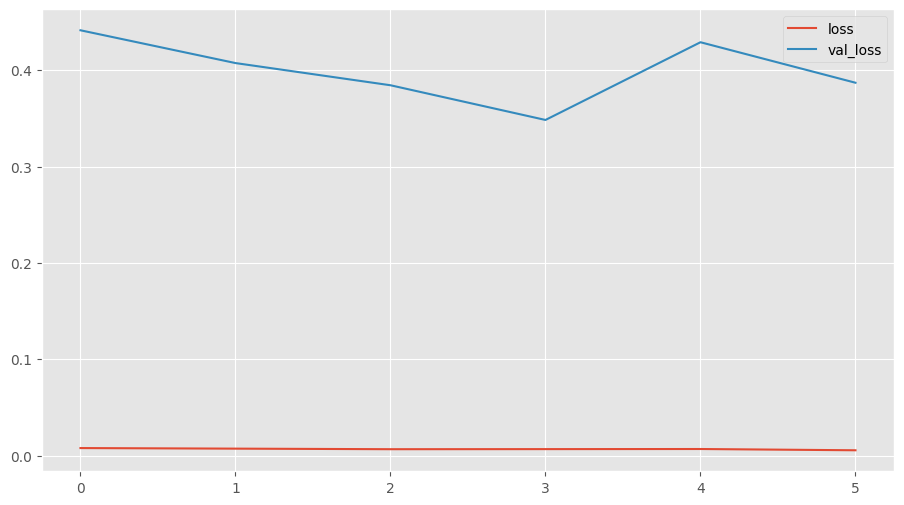

In [41]:
losses.plot();

#### Predictions

In [42]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape(1,length,n_features)

for i in range(len(test)):
    #get prediction 1 timestamp ahead([0] is for grabbing just the first number)
    current_pred = model.predict(current_batch)[0]
    #store the predictions
    test_predictions.append(current_pred)
    #update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


In [43]:
#remove the scale from the test batch
true_predictions = scaler.inverse_transform(test_predictions)

In [44]:
test['Predictions'] = true_predictions

In [45]:
test

,Sales,Predictions
DATE,,
1993-07-01,9794,9118.707083
1993-08-01,10628,9130.218055
1993-09-01,10013,9076.725029
1993-10-01,10346,9032.250083
1993-11-01,11760,8953.261003
...,...,...
2019-06-01,21123,8252.291747
2019-07-01,21714,8252.291747
2019-08-01,23791,8252.291747


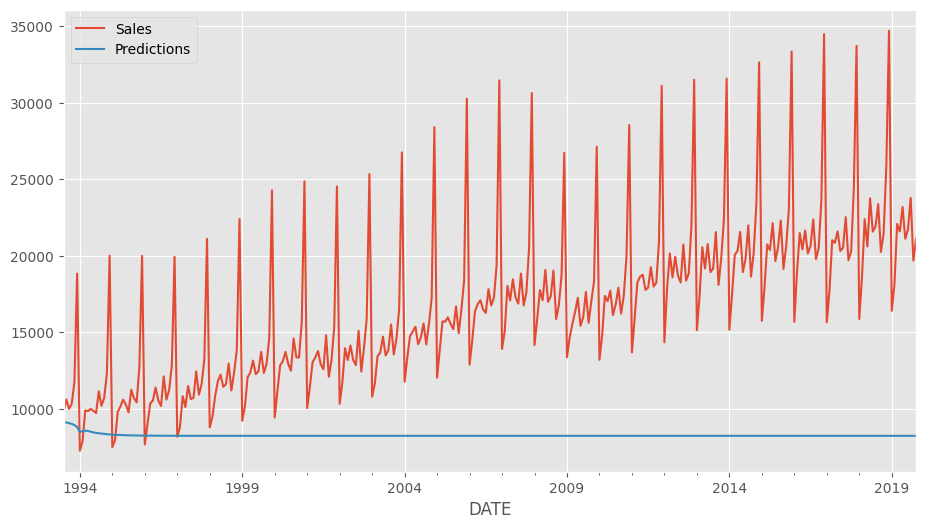

In [46]:
test.plot();

#### forecast

In [47]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [48]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data,
                                length=length, batch_size=1)

In [49]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [51]:
model.fit_generator(generator,epochs=8,
                    validation_data=validation_generator, 
                    )

Epoch 1/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0072 - val_loss: 22.8925
Epoch 2/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0042 - val_loss: 6.7354
Epoch 3/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0022 - val_loss: 6.8957
Epoch 4/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0033 - val_loss: 3.8634
Epoch 5/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0019 - val_loss: 1.3303
Epoch 6/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.4234
Epoch 7/8
322/322 [==============================] - 1s 5ms/step - loss: 0.0014 - val_loss: 0.4660
Epoch 8/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0011 - val_loss: 0.4277


In [52]:
forecast = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape(1,length,n_features)

for i in range(12):
    current_pred = model.predict(current_batch)[0]
    
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

1/1 [==============================] - 0s 18ms/step


In [53]:
#get unscaled data
forecast = scaler.inverse_transform(forecast)

In [54]:
forecast

array([[ 9689.55003394],
       [10896.66895887],
       [10214.64718029],
       [10947.13319477],
       [13782.57580405],
       [19248.4341017 ],
       [ 7786.81528702],
       [ 8304.46935464],
       [ 9120.85170037],
       [10089.68881911],
       [10362.60631499],
       [10119.06813055]])

In [57]:
forecast_index = pd.date_range(start='2019-11-01', periods=12,
                              freq="MS")

In [58]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index, columns=['forecast'])

In [59]:
forecast_df

,forecast
2019-11-01,9689.550034
2019-12-01,10896.668959
2020-01-01,10214.647180
2020-02-01,10947.133195
2020-03-01,13782.575804
2020-04-01,19248.434102
2020-05-01,7786.815287
2020-06-01,8304.469355
2020-07-01,9120.851700
2020-08-01,10089.688819


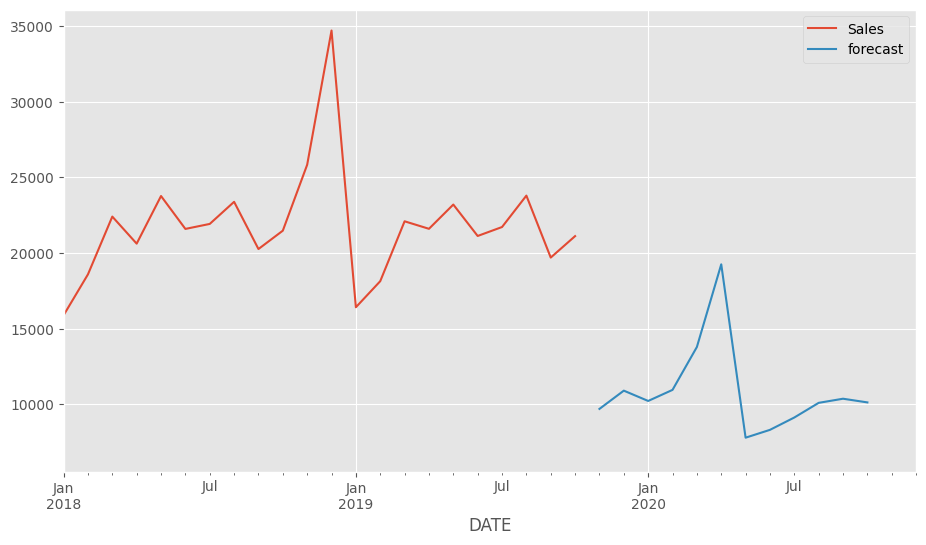

In [61]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01', '2020-12-01');